# Differentiation vs. integration approach

# Purpose
The paper claims that the integration approch is better than the differentiation approach as a Parameter Identification Technique. This notebook investigates this statement.

# Methodology
PIT using the two methods is used on a simulated signal with Gaus distributed measurement noise.

# Setup

In [1]:
# %load imports.py
"""
These is the standard setup for the notebooks.
"""

%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
import copy
from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorLinear
import src.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify, run
import rolldecayestimators.symbols as symbols
import sympy as sp

from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex

from sklearn.metrics import r2_score
import shipflowmotionshelpers.shipflowmotionshelpers as helpers
import src.visualization.visualize as visualize
import scipy
from copy import deepcopy
import joblib

Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


In [2]:
from rolldecayestimators.direct_estimator_cubic import EstimatorCubic,EstimatorQuadraticB
from sklearn.base import clone
from copy import deepcopy
from numpy.random import normal

import reports.examples.analytical_numerical

In [3]:
eq_phi1d = sp.Eq(symbols.phi_dot_dot,
      sp.solve(equations.roll_decay_equation_quadratic_A,symbols.phi_dot_dot)[0])

accelaration_lambda = lambdify(sp.solve(eq_phi1d,symbols.phi_dot_dot)[0])

In [4]:
omega0_eq = equations.omega0_equation.subs(symbols.C,symbols.C_1)
omega0_lambda = lambdify(sp.solve(omega0_eq, symbols.omega0)[0])

In [5]:

df = reports.examples.analytical_numerical.show(omega0_lambda=omega0_lambda, 
                                                accelaration_lambda=accelaration_lambda, plot=False)
df_true = df.drop(columns=['phi1d'])

In [6]:
df_true.head()

,phi
0.00,0.174533
0.01,0.174489
0.02,0.174359
0.03,0.174142
0.04,0.173838


In [7]:
df_measure = df_true.copy()
np.random.seed(42)
df_measure['noise'] = normal(loc=0, scale=np.deg2rad(0.5), size=len(df_measure))
df_measure['phi']+=df_measure['noise']

## Analyze the damping

In [8]:
np.random.seed(42)
lowpass_filter = LowpassFilterDerivatorTransformer(cutoff=1, minimum_score=0.0)
cutter = CutTransformer(phi_max=np.deg2rad(15), phi_min=np.deg2rad(0), phi1d_start_tolerance=0.015)
offset_transformer = OffsetTransformer()

<AxesSubplot:>

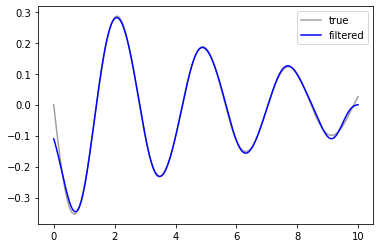

In [9]:
fig,ax=plt.subplots()

df.plot(y='phi1d',style='-', color='grey', label='true', ax=ax, alpha=0.75)

lowpass_filter.fit(df_measure).transform(df_measure).plot(y='phi1d',style='b-', label='filtered', ax=ax)

In [10]:
np.random.seed(42)
estimator_diff = EstimatorLinear(fit_method='derivation', maxfev=100000)

steps = [
    ('filter',lowpass_filter),
    #('cutter', cutter), 
    ('estimator', estimator_diff)
]

pipline_estimator_diff = Pipeline(steps=steps)
pipline_estimator_diff.fit(X=df_measure[['phi']])
df_diff = pipline_estimator_diff.predict(df_true)
pipline_estimator_diff.score(df_true)

0.9262226087157728

In [11]:
pipline_estimator_diff['estimator'].parameters

{'C_1A': 4.528247565167409, 'B_1A': 0.3300282442976332}

In [12]:
estimator_int= EstimatorLinear(fit_method='integration', maxfev=100000, p0=estimator_diff.parameters)

steps = [
    ('filter',lowpass_filter),
    #('cutter', cutter), 
    ('estimator', estimator_int)
]

pipline_estimator_int = Pipeline(steps=steps)
pipline_estimator_int.fit(X=df_measure[['phi']])
df_int = pipline_estimator_int.predict(df_true)
pipline_estimator_int.score(df_true)

0.9802886393850015

In [13]:
pipline_estimator_int['estimator'].parameters

{'C_1A': 4.74725600798353, 'B_1A': 0.3261232770509625}

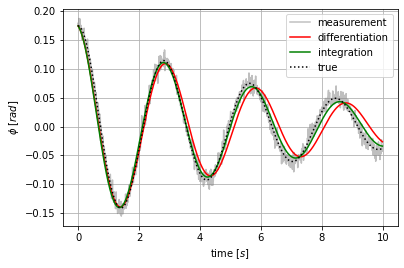

In [14]:
fig,ax=plt.subplots()

df_measure.plot(y='phi',style='-', color='grey', label='measurement', ax=ax, alpha=0.5)
df_diff.plot(y='phi',style='r-', label='differentiation', ax=ax)
df_int.plot(y='phi',style='g-', label='integration', ax=ax)
df_true.plot(y='phi',style='k:', label='true', ax=ax)

ax.set_ylabel(r'$\phi$ $[rad]$')
ax.set_xlabel(r'time $[s]$')
ax.grid(True)
ax.legend()

In [15]:
df_compare = df_true.copy()

frames = {
    'measure' : df_measure,
    'diff' : df_diff,
    'int' : df_int,
}

for name, df_ in frames.items():
    
    df_compare = pd.merge(left=df_compare, right=df_[['phi']], how='left', 
                      left_index=True, right_index=True, suffixes=('','_%s' % name))

df_compare_diff = df_compare.sub(df_compare['phi'], axis='rows')

<AxesSubplot:>

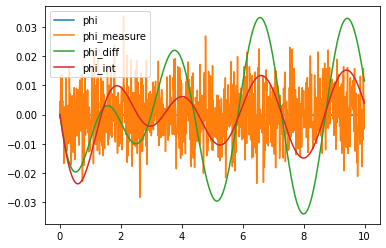

In [16]:
df_compare_diff.plot()

## Vary filter:

In [17]:
def vary_cutoff(cutoff:float, fit_method:str): 
    
    lowpass_filter = LowpassFilterDerivatorTransformer(cutoff=cutoff, minimum_score=0.0)
      
    estimator = EstimatorLinear(fit_method='derivation', maxfev=100000)
    steps = [
        ('filter',lowpass_filter),
        ('estimator', estimator)
    ]
    
    pipeline = Pipeline(steps=steps)
    pipeline.fit(X=df_measure[['phi']])
    
    if fit_method is 'integration':
        estimator = EstimatorLinear(fit_method='integration', maxfev=100000, 
                                         p0=estimator.parameters)
        steps = [
            ('filter',lowpass_filter),
            ('cutter', cutter), 
            ('estimator', estimator)
        ]
        pipeline = Pipeline(steps=steps)
        pipeline.fit(X=df[['phi']])
    
    return pipeline['estimator'].parameters

In [18]:
N = 10
np.random.seed(42)

cutoffs = np.linspace(0.7,6,N)
df_vary = pd.DataFrame()
for cutoff in cutoffs:
    
    for method in ['differentiation','integration']:
        s = pd.Series(vary_cutoff(cutoff=cutoff, fit_method=method))
        s['method'] = method
        s['cutoff'] = cutoff
        df_vary = df_vary.append(s, ignore_index=True)
    
 
    

In [19]:
s_true = pd.Series()
A_44 = 1.0
B_1 = 0.3
C_1 = 5.0
s_true['B_1A'] = B_1/A_44
s_true['B_2A'] = 0

s_true['C_1A'] = C_1/A_44
s_true['C_3A'] = 0
s_true['C_5A'] = 0


In [20]:
s_true

B_1A    0.3
B_2A    0.0
C_1A    5.0
C_3A    0.0
C_5A    0.0
dtype: float64

In [21]:
df_error = df_vary.select_dtypes(exclude='object').sub(s_true).abs()
df_error['method'] = df_vary['method']
df_error['cutoff'] = df_vary['cutoff']

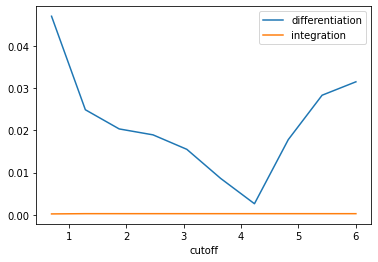

In [22]:
fig,ax=plt.subplots()
for method, df_ in df_error.groupby(by='method'):
    df_.plot(x='cutoff', y='B_1A', ax=ax, label=method)


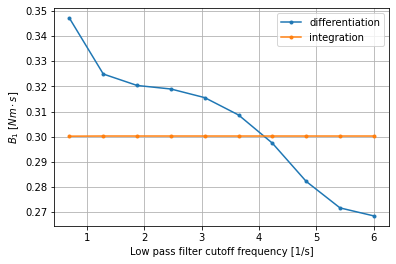

In [23]:
fig,ax=plt.subplots()
for method, df_ in df_vary.groupby(by='method'):
    df_.plot(x='cutoff', y='B_1A', style='.-', ax=ax, label=method)
    
ax.set_ylabel(r'$B_1$ $[Nm \cdot s]$')
ax.set_xlabel(r'Low pass filter cutoff frequency [1/s]')
ax.grid(True)

In [24]:
x,y,z = sp.symbols('x y z')
expression = x + y - z
expression

x + y - z

In [25]:
expression.func

sympy.core.add.Add

In [26]:
expression.args

(x, y, -z)

In [27]:
X = lowpass_filter.fit(df_measure).transform(df_measure)
X.head()

,phi,noise,phi_filtered,phi1d,phi2d
0.00,0.178868,0.004335,0.183017,-0.110489,-0.172108
0.01,0.173283,-0.001207,0.181912,-0.112210,-0.259432
0.02,0.180011,0.005652,0.180773,-0.115677,-0.349288
0.03,0.187432,0.013291,0.179599,-0.119195,-0.354329
0.04,0.171795,-0.002043,0.178389,-0.122764,-0.359324


In [28]:
subs = [
    (equations.new_symbols[symbols.B_2],0),
    (equations.new_symbols[symbols.B_3],0),
    (equations.new_symbols[symbols.C_3],0),
    (equations.new_symbols[symbols.C_5],0),    
]
eq = equations.roll_decay_equation_cubic_A.subs(subs)
eq

Eq(B_1A*Derivative(phi(t), t) + C_1A*phi(t) + Derivative(phi(t), (t, 2)), 0)

In [29]:
lhs = eq.lhs
lhs.free_symbols

{B_1A, C_1A, t}

In [30]:
for arg in lhs.args:
    lambdify(arg)

In [31]:
arg

Derivative(phi(t), (t, 2))

In [32]:
def remove_free(arg):
    new_arg = arg.copy()
    for symbol in arg.free_symbols:
        if symbol.name == symbols.t.name:
            continue 
        new_arg = new_arg.subs(symbol,1)
    return new_arg

In [33]:
def create_features_and_label(X, lhs):
    
    args = []
    free_symbols = []
    
    for arg in lhs.args:
        new_arg = remove_free(arg)
                
        f = list(arg.free_symbols - set([sp.symbols('t')]))
        if len(f) == 0:
            y_arg = new_arg
        elif len(f) == 1:
            free_symbol = f[0]  # assuming one...
            free_symbols.append(free_symbol)
            args.append(new_arg)
        elif len(f) > 1:
            raise ValueError('More than one free symbol')
        
    datas = []
    for arg in args:
        func = lambdify(arg)
        datas.append(run(func, X))
    X_ = np.array(datas).T
    
    y_func = lambdify(y_arg)
    y_ = -run(y_func, X)
    
    return X_, y_, free_symbols

In [41]:
X_, y_, free_symbols = create_features_and_label(X=X, lhs=eq.lhs)

In [35]:
p, res, rnk, s = scipy.linalg.lstsq(X_, y_)
p

array([0.33002824, 4.52824757])

In [36]:
free_symbols

[B_1A, C_1A]

In [37]:
eq2 = sp.Eq(symbols.phi,
            sp.solve(eq,symbols.phi)[0])
eq2

Eq(phi(t), -(B_1A*Derivative(phi(t), t) + Derivative(phi(t), (t, 2)))/C_1A)

In [42]:
def simulate(X,p):
    B_1A_ = p[0]
    C_1A_ = p[1]
    
    phi = -B_1A_/C_1A_*X['phi1d'] -X['phi2d']/C_1A_
    return phi

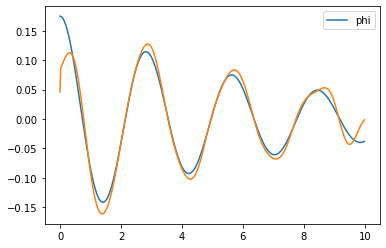

In [43]:
#phi = X_2.dot(p)
phi = simulate(X=X,p=p)

fig,ax=plt.subplots()
df_true.plot(y='phi', ax=ax)
ax.plot(df_true.index, phi)

In [52]:
def vary_cutoff2(df:pd.DataFrame, cutoff:float, eq): 
    lowpass_filter = LowpassFilterDerivatorTransformer(cutoff=cutoff, minimum_score=0.0)
    X = lowpass_filter.fit(df).transform(df)
    
    X_, y_, free_symbols = create_features_and_label(X=X, lhs=eq.lhs)
        
    return scipy.linalg.lstsq(X_, y_)
    

In [53]:
df_vary2 = pd.DataFrame()

for cutoff in cutoffs:
    
    p, res, rnk, s = vary_cutoff2(df=df_measure, cutoff=cutoff, eq=eq)
    
    s = pd.Series(name=cutoff)    
    s['B_1A'] = p[0]
    s['C_1A'] = p[1]
    df_vary2 = df_vary2.append(s)

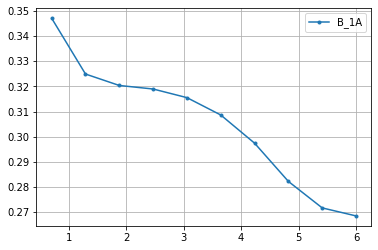

In [58]:
fig,ax=plt.subplots()
df_vary2.plot(y='B_1A', style='.-', ax=ax)
ax.grid(True)